# Packages

In [2]:
library(mdsr)
library(rpart)
library(partykit)
library(rattle)
library(randomForest)
library(nnet)
library(class)
library(e1071)
library(ROCR)
library(gridExtra)

# Init 

In [3]:
census <- read.csv(
  "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
  header = FALSE)
names(census) <- c("age", "workclass", "fnlwgt", "education",
                   "education.num", "marital.status", "occupation", "relationship",
                   "race", "sex", "capital.gain", "capital.loss", "hours.per.week",
                   "native.country", "income")
set.seed(364)
n <- nrow(census)
test_idx <- sample.int(n, size = round(0.2 * n))
train <- census[-test_idx,]
test <- census[test_idx,]

form <- as.formula("income ~ age + workclass + education + marital.status +
  occupation + relationship + race + sex + capital.gain + capital.loss +
  hours.per.week")

# Decision Tree

In [4]:
mod_tree <- rpart(form, data = train)
income_tree_probs <- mod_tree %>% 
  predict(newdata = test, type = "prob") %>% 
  as.data.frame()
income_tree_probs %>% head()

,<=50K,>50K
6724,0.7022832,0.29771678
190,0.2799435,0.72005650
30300,0.9506226,0.04937745
9395,0.9506226,0.04937745
24479,0.9506226,0.04937745
27235,0.9506226,0.04937745


A decision tree usually generates class labels for predictions instead of probabilities. However, we can use the probabilities from the leaf nodes of our decision tree as potential threshold values.

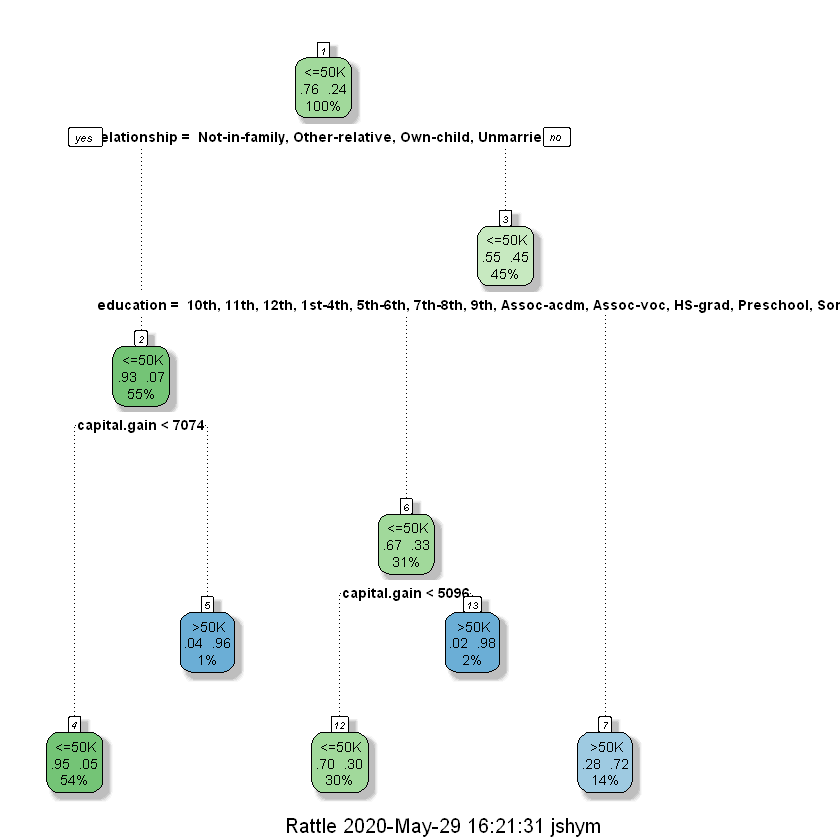

In [5]:
mod_tree %>% fancyRpartPlot()

As you can see from the tree above, our leaf node probabilities for classifiying an instance as `>50K` are 0.05, 0.96, 0.30, 0.98, and 0.72. Now, these are only five total threshold values, so our ROC curve will not look very smooth.

In [8]:
pred_tree <- ROCR::prediction(income_tree_probs$` >50K`, test$income)
perf_tree <- ROCR::performance(pred_tree, 'tpr', 'fpr')
perf_tree_df <- data.frame(perf_tree@x.values, perf_tree@y.values, perf_tree@alpha.values)
names(perf_tree_df) <- c("fpr", "tpr", "cut")
perf_tree_df

fpr,tpr,cut
0.0000000000,0.00000000,Inf
0.0006151323,0.07094801,0.98263027
0.0012302645,0.10764526,0.96470588
0.0492105803,0.51009174,0.72005650
0.3338117695,0.89113150,0.29771678
1.0000000000,1.00000000,0.04937745


Our ROC curve is only going to have 6 points, thus looking quite jagged.

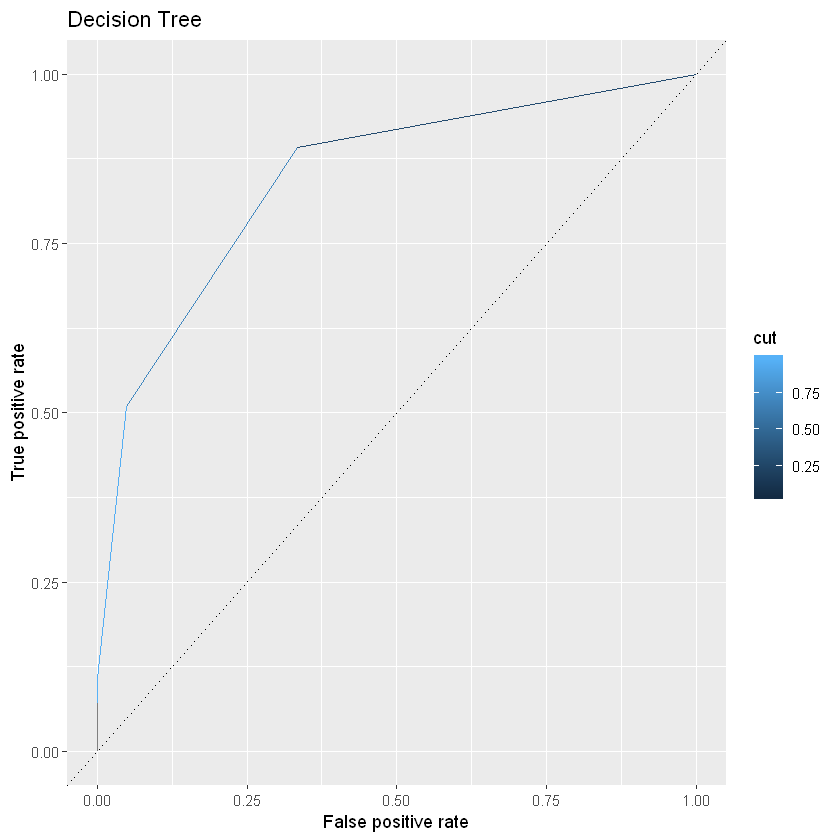

In [7]:
roc_tree <- perf_tree_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf_tree@y.name) + xlab(perf_tree@x.name) + ggtitle("Decision Tree")
roc_tree

# K-Nearest Neighbors

In order to use `knn()`, we have to first select only the quantitative variables from `train` and `test`. Then we need to obtain the proportion of winning votes for each prediction. Thus, we set `prob = TRUE`.

In [10]:
train_q <- train %>%
  select(age, education.num, capital.gain, capital.loss, hours.per.week)
test_q <- test %>% 
  select(age, education.num, capital.gain, capital.loss, hours.per.week)
income_knn <- knn(train_q, test = test_q, cl = train$income, k = 10, prob = TRUE)
income_knn %>% head(15)
income_knn %>% attr('prob') %>% head(15)

[1]  <=50K  <=50K  <=50K  <=50K  <=50K  <=50K  <=50K  <=50K  <=50K  <=50K
[11]  <=50K  <=50K  <=50K  <=50K  >50K 
Levels:  <=50K  >50K

[1] 1.0000000 0.7000000 1.0000000 1.0000000 1.0000000 1.0000000 0.9411765
 [8] 0.7000000 0.8117647 0.9487179 0.7272727 0.7142857 0.7272727 1.0000000
[15] 1.0000000

All the proportions returned are > 0.5. Therefore, we need to convert all proportions to reflect the proportion of votes in favor of `>50K`.

In [12]:
income_knn_probs <- matrix(nrow = length(income_knn), ncol = 1)
for(i in 1:length(income_knn)) {
  p = attr(income_knn, 'prob')[i]
  income_knn_probs[i, 1] <- ifelse(income_knn[i] == ' >50K', p, 1 - p)
}
income_knn_probs <- income_knn_probs %>% as.data.frame()
names(income_knn_probs) <- c(' >50K')
income_knn_probs %>% head(15)

>50K
0.00000000
0.30000000
0.00000000
0.00000000
0.00000000
0.00000000
0.05882353
0.30000000
0.18823529
0.05128205


Now that we have probabilities relative to `>50K`, we can feed them into `ROCR::prediction()` per usual.

In [13]:
pred_knn <- ROCR::prediction(income_knn_probs$` >50K`, test$income)
perf_knn <- ROCR::performance(pred_knn, 'tpr', 'fpr')
perf_knn_df <- data.frame(perf_knn@x.values, perf_knn@y.values, perf_knn@alpha.values)
names(perf_knn_df) <- c("fpr", "tpr", "cut")
perf_knn_df %>% head()

fpr,tpr,cut
0.000000000,0.0000000,Inf
0.001435309,0.2691131,1.0000000
0.001435309,0.2697248,0.9333333
0.001435309,0.2709480,0.9285714
0.001640353,0.2727829,0.9166667
0.002050441,0.2770642,0.9090909


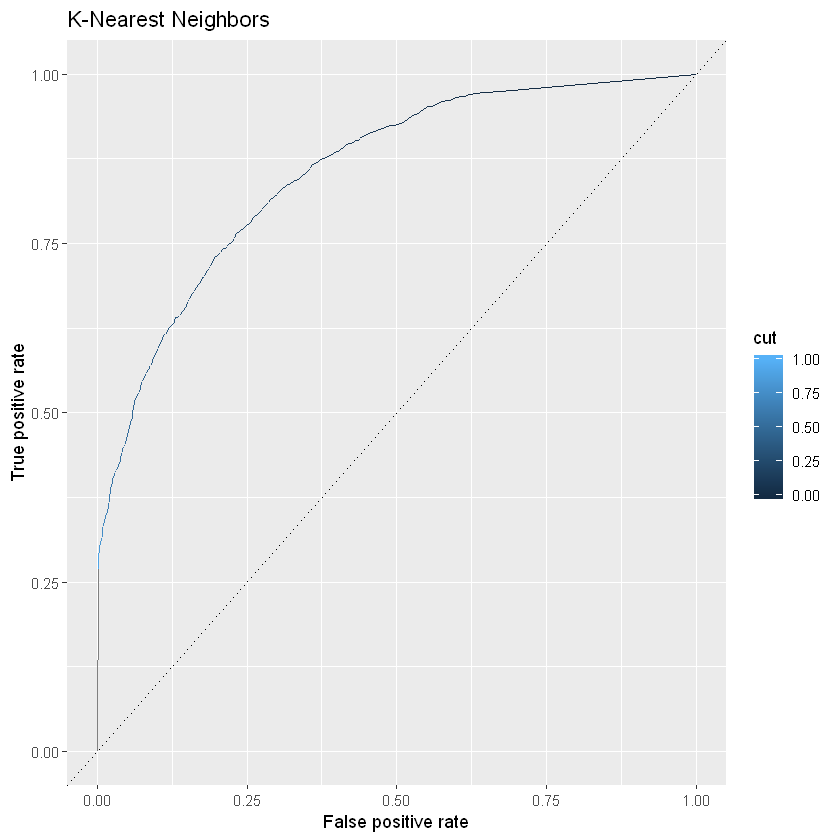

In [14]:
roc_knn <- perf_knn_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf_knn@y.name) + xlab(perf_knn@x.name) + ggtitle("K-Nearest Neighbors")
roc_knn

An interesting feature of this ROC curve is how steep it rises initially. Even with a threshold value of 1, the true positive rate is above 0.25, and the false positive rate is nearly 0.

# Naive Bayes

Naive Bayes can inherently return probabilities, so creating a ROC curve for it should be no problem.

In [15]:
mod_nb <- naiveBayes(form, data = train)
income_nb_probs <- mod_nb %>%
  predict(newdata = test, type = "raw") %>%
  as.data.frame()
income_nb_probs %>% head()

<=50K,>50K
2.433472e-06,9.999976e-01
8.548025e-01,1.451975e-01
9.997108e-01,2.891809e-04
1.000000e+00,1.430532e-08
9.999982e-01,1.754151e-06
9.999944e-01,5.580988e-06


In [16]:
pred_nb <- ROCR::prediction(income_nb_probs$` >50K`, test$income)
perf_nb <- ROCR::performance(pred_nb, 'tpr', 'fpr')
perf_nb_df <- data.frame(perf_nb@x.values, perf_nb@y.values, perf_nb@alpha.values)
names(perf_nb_df) <- c("fpr", "tpr", "cut")
perf_nb_df %>% head()

fpr,tpr,cut
0.000000000,0.00000000,Inf
0.001230265,0.08256881,1
0.001230265,0.08318043,1
0.001230265,0.08440367,1
0.001230265,0.08501529,1
0.001230265,0.08562691,1


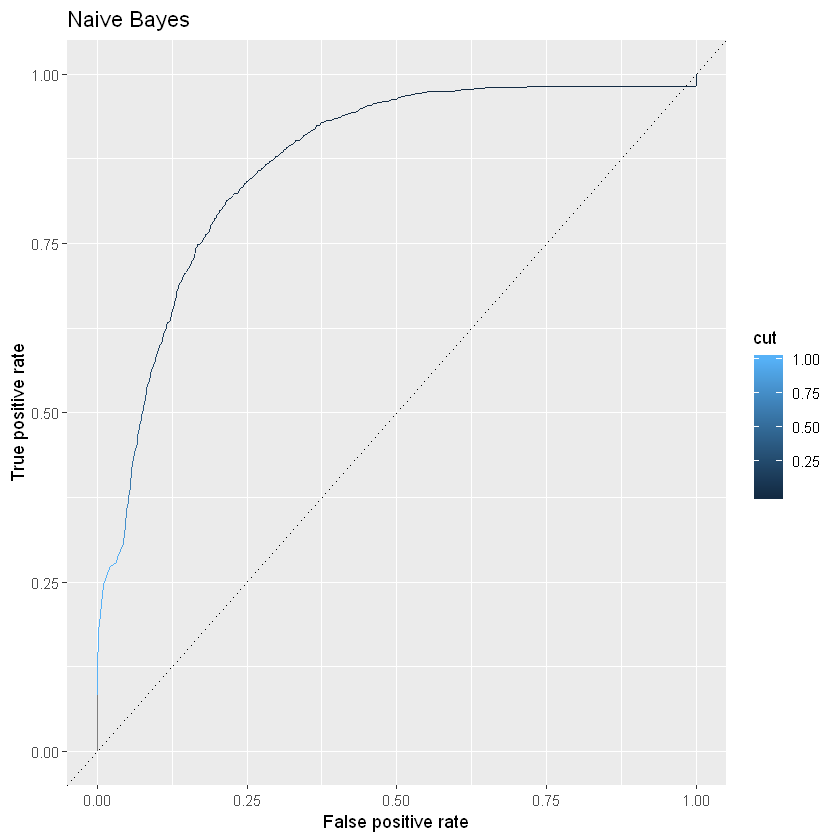

In [17]:
roc_nb <- perf_nb_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf_nb@y.name) + xlab(perf_nb@x.name) + ggtitle("Naive Bayes")
roc_nb

# Neural Network

Like Naive Bayes, Neural Network can also inherently return probabilities.

In [24]:
mod_nn <- nnet(form, data = train, size = 5)
income_nn_probs <- mod_nn %>% 
  predict(newdata = test, type = "raw") %>% 
  as.data.frame()
income_nn_probs %>% head()

# weights:  296
initial  value 15739.672367 
iter  10 value 13157.181646
iter  20 value 12366.646243
iter  30 value 9635.947516
iter  40 value 8922.598554
iter  50 value 8601.879992
iter  60 value 8509.959694
iter  70 value 8453.548378
iter  80 value 8404.202767
iter  90 value 8335.532215
iter 100 value 8301.633302
final  value 8301.633302 
stopped after 100 iterations


,V1
6724,0.577938784
190,0.637188478
30300,0.008737639
9395,0.001932969
24479,0.003995120
27235,0.004749456


In [25]:
pred_nn <- ROCR::prediction(income_nn_probs$V1, test$income)
perf_nn <- ROCR::performance(pred_nn, 'tpr', 'fpr')
perf_nn_df <- data.frame(perf_nn@x.values, perf_nn@y.values, perf_nn@alpha.values)
names(perf_nn_df) <- c("fpr", "tpr", "cut")
perf_nn_df %>% head()

fpr,tpr,cut
0,0.0000000000,Inf
0,0.0006116208,0.9875903
0,0.0012232416,0.9875902
0,0.0018348624,0.9875902
0,0.0024464832,0.9875901
0,0.0036697248,0.9875900


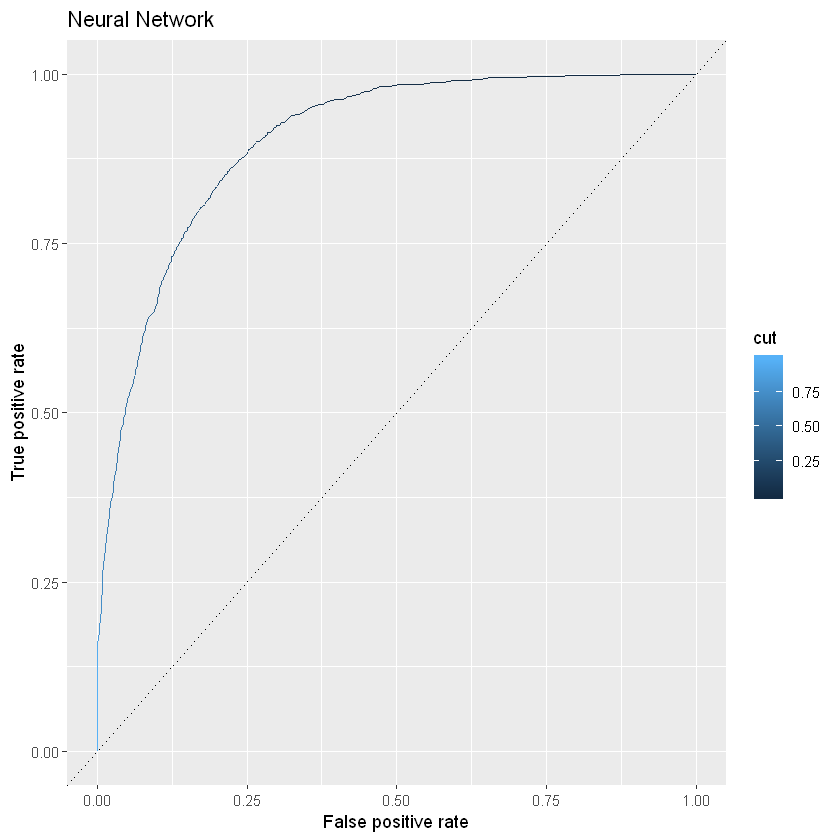

In [26]:
roc_nn <- perf_nn_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf_nn@y.name) + xlab(perf_nn@x.name) + ggtitle("Neural Network")
roc_nn

# Null Model

The null model ROC curve should simply be a line from (0,0) to (1,1).

In [27]:
mod_null <- glm(income ~ 1, data = train, family = binomial)
income_null_probs <- mod_null %>% 
  predict(newdata = test, type = "response") %>% 
  as.data.frame()
income_null_probs %>% head()

,.
6724,0.2382433
190,0.2382433
30300,0.2382433
9395,0.2382433
24479,0.2382433
27235,0.2382433


In [28]:
pred_null <- ROCR::prediction(income_null_probs$., test$income)
perf_null <- ROCR::performance(pred_null, 'tpr', 'fpr')
perf_null_df <- data.frame(perf_null@x.values, perf_null@y.values, perf_null@alpha.values)
names(perf_null_df) <- c("fpr", "tpr", "cut")
perf_null_df %>% head()

fpr,tpr,cut
0,0,Inf
1,1,0.2382433


This value of 0.24 simply implies that ~24% of the training data were instances with `>50K` income.

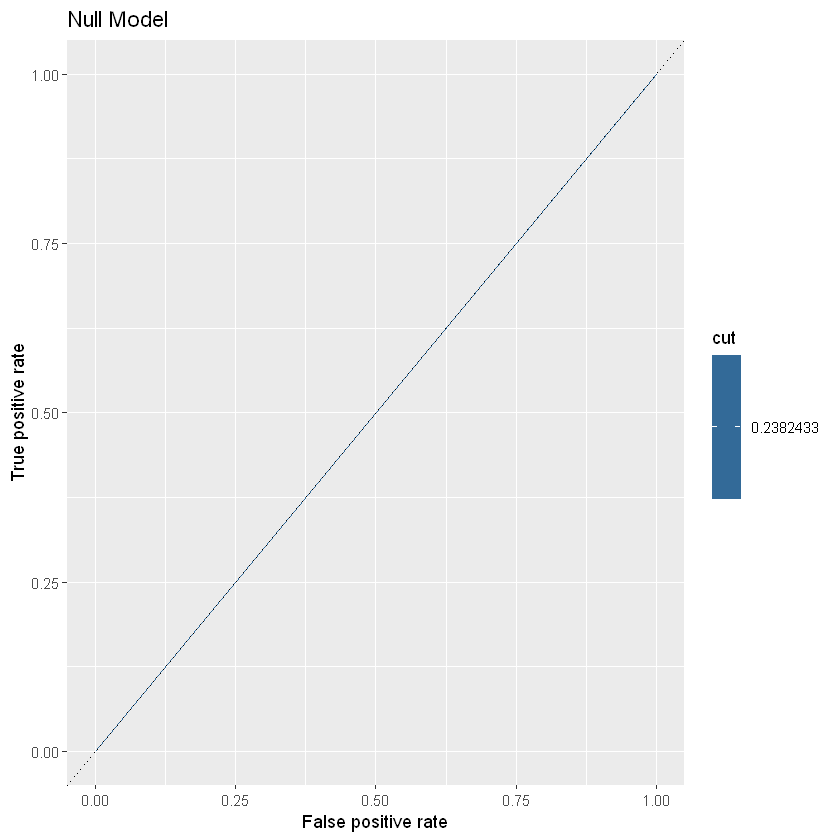

In [30]:
roc_null <- perf_null_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf_null@y.name) + xlab(perf_null@x.name) + ggtitle("Null Model")
roc_null

# Random Forest

Random Forest is quite similar to the Decision Tree model in terms of obtaining probabilities for thresholds. However, the resulting ROC curve should be significantly smoother since there are many more trees and thus many more leaf node probabilities.

In [31]:
mod_forest <- randomForest(form, data = train, ntree = 201, mtry = 3)
income_forest_probs <- mod_forest %>% 
  predict(newdata = test, type = "prob") %>% 
  as.data.frame()
income_forest_probs %>% head()

,<=50K,>50K
6724,0.8258706,0.1741294
190,0.7164179,0.2835821
30300,0.9800995,0.0199005
9395,1.0000000,0.0000000
24479,1.0000000,0.0000000
27235,1.0000000,0.0000000


In [32]:
pred_forest <- ROCR::prediction(income_forest_probs$` >50K`, test$income)
perf_forest <- ROCR::performance(pred_forest, 'tpr', 'fpr')
perf_forest_df <- data.frame(perf_forest@x.values, perf_forest@y.values, perf_forest@alpha.values)
names(perf_forest_df) <- c("fpr", "tpr", "cut")
perf_forest_df %>% head()

fpr,tpr,cut
0.0000000000,0.00000000,Inf
0.0006151323,0.06788991,1.0000000
0.0012302645,0.11009174,0.9950249
0.0016403527,0.14189602,0.9900498
0.0024605290,0.15718654,0.9850746
0.0028706172,0.17370031,0.9800995


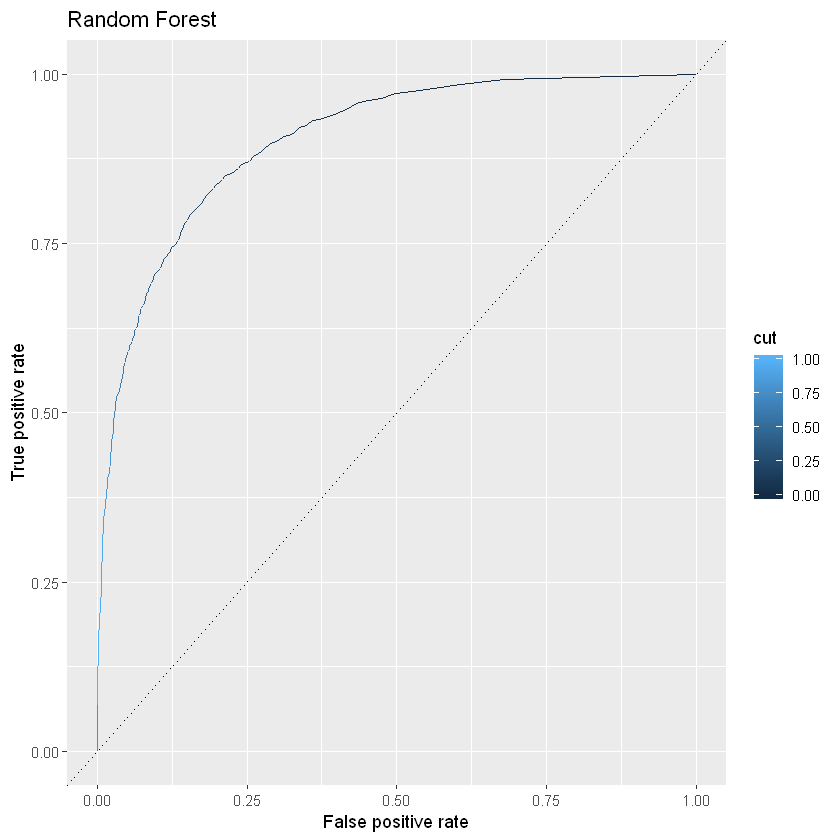

In [33]:
roc_forest <- perf_forest_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf_forest@y.name) + xlab(perf_forest@x.name) + ggtitle("Random Forest")
roc_forest

Note that this is not only smoother than the Decision Tree ROC curve, but also outperforms every other model nearly every time on this training and testing data. (Sometimes Neural Network's curve surpasses Random Forest's curve.)

# Graphing All Models

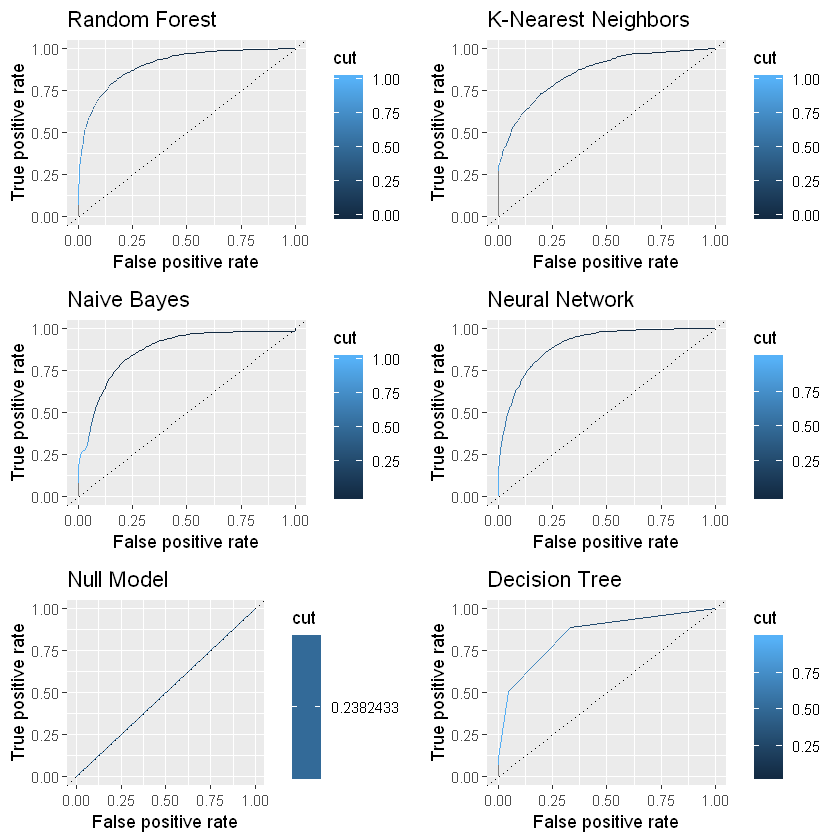

In [34]:
grid.arrange(roc_forest, roc_knn, roc_nb, roc_nn, roc_null, roc_tree)

Above are all the previous ROC curves placed side by side with their threshold gradients applied.

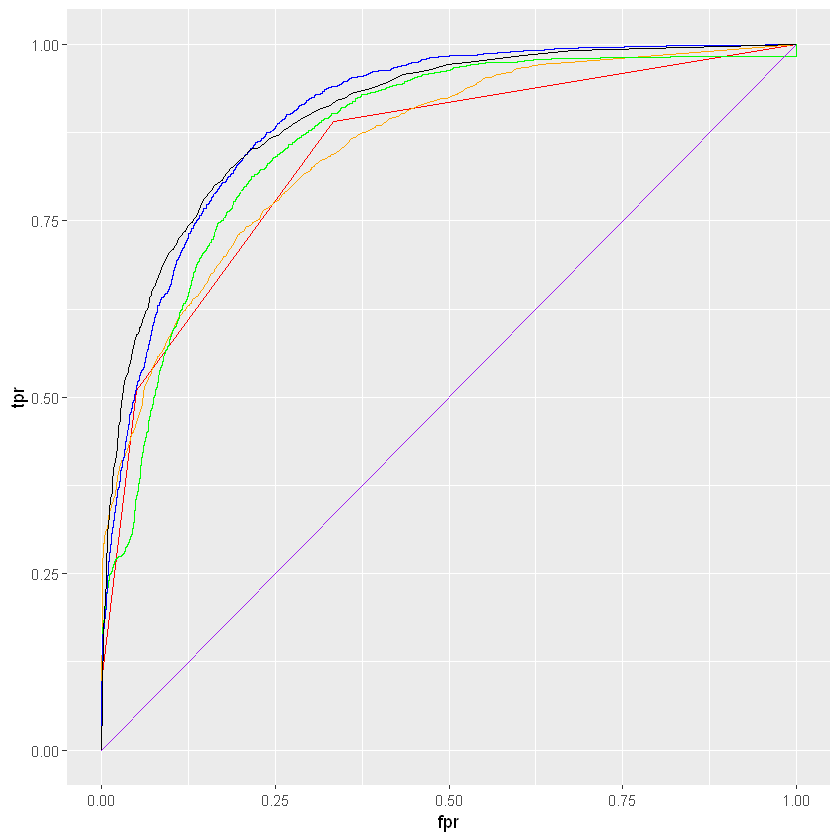

In [35]:
ggplot() + 
  geom_line(data = perf_tree_df, aes(x = fpr, y = tpr), color = "red") + 
  geom_line(data = perf_knn_df, aes(x = fpr, y = tpr), color = "orange") + 
  geom_line(data = perf_nb_df, aes(x = fpr, y = tpr), color = "green") + 
  geom_line(data = perf_nn_df, aes(x = fpr, y = tpr), color = "blue") + 
  geom_line(data = perf_null_df, aes(x = fpr, y = tpr), color = "purple") + 
  geom_line(data = perf_forest_df, aes(x = fpr, y = tpr), color = "black")

Apologies for the lack of a legend:  
Red = Decision Tree  
Orange = K-Nearest Neighbors  
Green = Naive Bayes  
Blue = Neural Network  
Purple = Null Model  
Black = Random Forest  
  
As you can see, Random Forest and Neural Network are the top performers.